In [1]:
# Import necessary libraries for the implementation
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch.nn as nn 
import torch.autograd as autograd
from torch.utils.data import DataLoader, Dataset, Subset, TensorDataset, ConcatDataset
from datasets import load_dataset
from transformers import AutoModel, AutoTokenizer
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import random
import os
import math

In [2]:
# Define paths and constants
DATASET_PATH = "scikit-fingerprints/MoleculeNet_Lipophilicity"  
MODEL_NAME = "ibm/MoLFormer-XL-both-10pct"  
BATCH_SIZE = 16  # Batch size for data loading
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Device for computation
SEED = 42  # Random seed for reproducibility
LR = 2e-5  # Learning rate for optimization
WEIGHT_DECAY = 0.01  # Weight decay for regularization
NUM_EPOCHS = 5  # Number of training epochs
MAX_LENGTH = 512  # Maximum sequence length

# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
set_seed(SEED)

print(f"Using device: {DEVICE}")

Using device: cuda


In [3]:
# This cell handles loading the external dataset that contains additional 
# molecules that might improve model performance

# Try to load the external dataset from the expected Kaggle path
try:
    # Attempt to load from the Kaggle path mentioned
    ext_data_path = "../input/external-dataset-csv/External-Dataset_for_Task2.csv"
    if os.path.exists(ext_data_path):
        ext_data = pd.read_csv(ext_data_path)
    else:
        # Try alternative paths
        alt_paths = [
            "External-Dataset-for-Task2.csv",
            "../tasks/External-Dataset_for_Task2.csv",
            "/kaggle/input/external-smiles/External-Dataset-for-Task2.csv"
        ]
        
        for path in alt_paths:
            if os.path.exists(path):
                ext_data = pd.read_csv(path)
                print(f"Loaded external dataset from {path}")
                break
        else:
            raise FileNotFoundError("External dataset file not found")
            
except Exception as e:
    print(f"Error loading external dataset: {e}")
    # Create a dummy dataset if needed for testing
    print("Creating a dummy external dataset for demonstration")
    ext_data = pd.DataFrame({
        'SMILES': ["CCC", "CCO", "CCN", "CC=O"],
        'Label': [1.2, 0.8, 1.5, 0.6]
    })

# Display information about the external dataset
print(f"External dataset loaded with {len(ext_data)} samples")
print("First few rows of the external dataset:")
display(ext_data.head())

# Check for missing values
print("\nMissing values in the external dataset:")
print(ext_data.isnull().sum())

# Show basic statistics
print("\nBasic statistics of the external dataset:")
print(ext_data.describe())

External dataset loaded with 300 samples
First few rows of the external dataset:


,SMILES,Label
0,CCCCN1Cc2c(nc3cc(-c4ccco4)nn3c2O)C1=O,1.548
1,Cc1cc(C)c2c(n1)sc1c2ncnc1N1CCN(C)CC1,2.568
2,COC(=O)[C@H]1[C@H]2CC[C@H](C[C@@H]1OC(=O)c1ccc...,0.102
3,Nc1nonc1/C(=N/O)Nc1ccc(F)c(Cl)c1,2.450
4,Cc1c[nH]c(/C=C2/C(=O)Nc3ccccc32)c1CCC(=O)O,1.040



Missing values in the external dataset:
SMILES    0
Label     0
dtype: int64

Basic statistics of the external dataset:
            Label
count  300.000000
mean     1.790927
std      0.878076
min     -0.338000
25%      1.242500
50%      1.898000
75%      2.372500
max      4.028000


In [4]:
# This cell defines classes for the model architecture and datasets
class MoLFormerWithRegressionHead(nn.Module):
    def __init__(self, base_model, dropout_rate=0.1):
        """
        Model architecture that combines MoLFormer with a regression head.
        
        Args:
            base_model: Pre-trained MoLFormer model
            dropout_rate: Dropout probability for regularization
        """
        super().__init__()
        
        # Base MoLFormer model
        self.base_model = base_model
        
        # Get the hidden size from the base model config
        hidden_size = base_model.config.hidden_size
        
        # Regression head with dropout for regularization
        self.regression_head = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.GELU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size // 2, 1)
        )
        
    def forward(self, input_ids, attention_mask):
        """
        Forward pass of the model.
        
        Args:
            input_ids: Tokenized input sequences
            attention_mask: Attention mask for the sequences
            
        Returns:
            Predicted values (logits)
        """
        # Pass through base model
        outputs = self.base_model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        
        # Use the [CLS] token representation for regression
        sequence_output = outputs.last_hidden_state[:, 0, :]
        
        # Pass through regression head and remove extra dimension
        logits = self.regression_head(sequence_output)
        
        return logits.squeeze(-1)  # Remove last dimension for single value prediction

In [5]:
class SMILESDataset(Dataset):
    def __init__(self, data, tokenizer, max_length=512):
        """
        Dataset for SMILES strings with lipophilicity labels.
        
        Args:
            data: Dataset containing SMILES strings and labels
            tokenizer: Tokenizer for processing SMILES strings
            max_length: Maximum length for padding/truncation
        """
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        """Return the number of samples in the dataset."""
        return len(self.data)
    
    def __getitem__(self, idx):
        """
        Get a single sample from the dataset.
        
        Args:
            idx: Index of the sample to retrieve
            
        Returns:
            Dictionary containing input_ids, attention_mask, and labels
        """
        # Handle Subset indexing
        if isinstance(self.data, Subset):
            item = self.data.dataset[self.data.indices[idx]]
        else:
            item = self.data[idx]
        
        # Get the SMILE and target
        smiles = item['SMILES']
        target = item['Label'] if 'Label' in item else item['label']
        
        # Tokenize the SMILES string
        encoding = self.tokenizer(
            smiles,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        # Remove the batch dimension added by the tokenizer
        input_ids = encoding['input_ids'].squeeze(0)
        attention_mask = encoding['attention_mask'].squeeze(0)
        
        # Convert target to tensor
        target = torch.tensor(target, dtype=torch.float32)
        
        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': target
        }

In [6]:
class ExternalSMILESDataset(Dataset):
    """
    Dataset class specifically for the external dataset.
    """
    def __init__(self, dataframe, tokenizer, max_length=512):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        # Get the SMILES string and label from the DataFrame
        smiles = self.dataframe.iloc[idx]['SMILES']
        label = self.dataframe.iloc[idx]['Label']
        
        # Tokenize the SMILES string
        encoding = self.tokenizer(
            smiles,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        # Remove the batch dimension
        input_ids = encoding['input_ids'].squeeze(0)
        attention_mask = encoding['attention_mask'].squeeze(0)
        
        # Convert label to tensor
        label = torch.tensor(label, dtype=torch.float32)
        
        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': label
        }

# Load tokenizer for processing SMILES strings
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, trust_remote_code=True)

# Load original dataset
dataset = load_dataset(DATASET_PATH)
print(f"Dataset loaded with {len(dataset['train'])} samples")

tokenizer_config.json:   0%|          | 0.00/1.29k [00:00<?, ?B/s]

tokenization_molformer_fast.py:   0%|          | 0.00/6.50k [00:00<?, ?B/s]

tokenization_molformer.py:   0%|          | 0.00/9.48k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/ibm/MoLFormer-XL-both-10pct:
- tokenization_molformer.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/ibm/MoLFormer-XL-both-10pct:
- tokenization_molformer_fast.py
- tokenization_molformer.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


vocab.json:   0%|          | 0.00/41.6k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/54.0k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/1.16k [00:00<?, ?B/s]

lipophilicity.csv:   0%|          | 0.00/223k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/4200 [00:00<?, ? examples/s]

Dataset loaded with 4200 samples


In [7]:
# Split the dataset into training and test sets
def split_dataset(dataset, tokenizer, test_size=0.2, random_state=42):
    """
    Split a dataset into training and test sets.
    
    Args:
        dataset: HuggingFace dataset to split
        tokenizer: Tokenizer for processing SMILES strings
        test_size: Proportion of dataset to use for testing
        random_state: Random seed for reproducibility
    
    Returns:
        train_data: SMILESDataset for training
        test_data: SMILESDataset for testing
    """
    # Set random seeds for reproducibility
    set_seed(random_state)
    
    # Get total number of samples
    total_samples = len(dataset['train'])
    
    # Generate random indices for splitting
    indices = list(range(total_samples))
    random.shuffle(indices)
    
    # Calculate split point
    split_idx = int(total_samples * (1 - test_size))
    
    # Split indices into train and test
    train_indices = indices[:split_idx]
    test_indices = indices[split_idx:]
    
    # Create Subset datasets
    train_dataset = Subset(dataset['train'], train_indices)
    test_dataset = Subset(dataset['train'], test_indices)
    
    # Create SMILES datasets with the tokenizer
    train_data = SMILESDataset(train_dataset, tokenizer)
    test_data = SMILESDataset(test_dataset, tokenizer)
    
    # Print dataset sizes
    print(f"Total dataset size: {total_samples}")
    print(f"Training set size: {len(train_data)}")
    print(f"Test set size: {len(test_data)}")
    
    return train_data, test_data

# Split the dataset
train_data, test_data = split_dataset(dataset, tokenizer)

# Create dataloaders
train_loader = DataLoader(
    train_data, 
    batch_size=BATCH_SIZE, 
    shuffle=True
)

test_loader = DataLoader(
    test_data, 
    batch_size=BATCH_SIZE, 
    shuffle=False
)

# Create external dataset loader
external_dataset = ExternalSMILESDataset(ext_data, tokenizer)
external_loader = DataLoader(
    external_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)

print(f"External dataset size: {len(external_dataset)}")

# Load pre-trained model
print("Loading pre-trained MoLFormer model...")
base_model = AutoModel.from_pretrained(MODEL_NAME, trust_remote_code=True)
model = MoLFormerWithRegressionHead(base_model).to(DEVICE)

# Try to load pre-trained model from Task 2
try:
    # First try to load the best model from Task 2
    model.load_state_dict(torch.load("new_best_model.pth", map_location=DEVICE))
    print("Successfully loaded pre-trained model from Task 2")
except FileNotFoundError:
    print("Pre-trained model not found, will need to train from scratch")
    # We would train the model here if needed

Total dataset size: 4200
Training set size: 3360
Test set size: 840
External dataset size: 300
Loading pre-trained MoLFormer model...


config.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

configuration_molformer.py:   0%|          | 0.00/7.60k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/ibm/MoLFormer-XL-both-10pct:
- configuration_molformer.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_molformer.py:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/ibm/MoLFormer-XL-both-10pct:
- modeling_molformer.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors:   0%|          | 0.00/187M [00:00<?, ?B/s]

Pre-trained model not found, will need to train from scratch


<ipython-input-7-146369b091ab>:82: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("new_best_model.pth", map_location=DEVICE))


In [9]:
# ======================= DATA SELECTION STRATEGIES =======================

# 1. Random Selection Method
def random_selection(dataset, percentage=0.1):
    """
    Randomly select a subset of the data.
    
    Args:
        dataset: Dataset to select from
        percentage: Percentage of data to select
        
    Returns:
        Selected dataframe
    """
    num_samples = int(len(dataset) * percentage)
    selected_indices = random.sample(range(len(dataset)), num_samples)
    
    selected_df = pd.DataFrame({
        'SMILES': [dataset.dataframe.iloc[i]['SMILES'] for i in selected_indices],
        'Label': [dataset.dataframe.iloc[i]['Label'] for i in selected_indices]
    })
    
    return selected_df


In [10]:
# 2. Diversity-based Selection Method
def diversity_based_selection(dataset, model, tokenizer, percentage=0.1, n_clusters=10):
    """
    Select a diverse subset of the data based on molecular embeddings.
    
    Args:
        dataset: Dataset to select from
        model: Pre-trained model to extract embeddings
        tokenizer: Tokenizer for processing SMILES strings
        percentage: Percentage of data to select
        n_clusters: Number of clusters for K-means
        
    Returns:
        Selected dataframe
    """
    model.eval()
    embeddings = []
    
    # Extract embeddings for each molecule
    with torch.no_grad():
        for i in range(len(dataset)):
            smiles = dataset.dataframe.iloc[i]['SMILES']
            
            # Tokenize the SMILES string
            encoding = tokenizer(
                smiles,
                max_length=MAX_LENGTH,
                padding='max_length',
                truncation=True,
                return_tensors='pt'
            ).to(DEVICE)
            
            # Forward pass to get embedding
            outputs = model.base_model(
                input_ids=encoding['input_ids'],
                attention_mask=encoding['attention_mask']
            )
            
            # Get the [CLS] token representation
            embedding = outputs.last_hidden_state[:, 0, :].cpu().numpy()
            embeddings.append(embedding[0])
    
    # Convert to numpy array
    embeddings = np.array(embeddings)
    
    # Apply t-SNE for dimensionality reduction
    print("Applying t-SNE for dimensionality reduction...")
    tsne = TSNE(n_components=2, random_state=SEED)
    embeddings_2d = tsne.fit_transform(embeddings)
    
    # Apply K-means clustering
    print(f"Applying K-means clustering with {n_clusters} clusters...")
    kmeans = KMeans(n_clusters=n_clusters, random_state=SEED)
    clusters = kmeans.fit_predict(embeddings_2d)
    
    # Determine number of samples per cluster
    num_samples = int(len(dataset) * percentage)
    samples_per_cluster = num_samples // n_clusters
    
    # Select samples from each cluster
    selected_indices = []
    for cluster_id in range(n_clusters):
        cluster_indices = np.where(clusters == cluster_id)[0]
        
        if len(cluster_indices) > 0:
            # Select samples from the current cluster
            if len(cluster_indices) <= samples_per_cluster:
                selected_indices.extend(cluster_indices)
            else:
                # Select the sample closest to the centroid
                centroid = kmeans.cluster_centers_[cluster_id]
                distances = np.sqrt(np.sum((embeddings_2d[cluster_indices] - centroid)**2, axis=1))
                sorted_within_cluster = cluster_indices[np.argsort(distances)]
                selected_indices.extend(sorted_within_cluster[:samples_per_cluster])
    
    # If we haven't selected enough samples, add more randomly
    if len(selected_indices) < num_samples:
        remaining = num_samples - len(selected_indices)
        available_indices = list(set(range(len(dataset))) - set(selected_indices))
        if available_indices:
            additional_indices = random.sample(available_indices, min(remaining, len(available_indices)))
            selected_indices.extend(additional_indices)
    
    # Create a dataframe with the selected samples
    selected_df = pd.DataFrame({
        'SMILES': [dataset.dataframe.iloc[i]['SMILES'] for i in selected_indices],
        'Label': [dataset.dataframe.iloc[i]['Label'] for i in selected_indices]
    })
    
    return selected_df

In [11]:
# 3. Property Range Selection Method
def property_range_selection(dataset, percentage=0.1, n_bins=10):
    """
    Select samples to ensure coverage across the entire property range.
    
    Args:
        dataset: Dataset to select from
        percentage: Percentage of data to select
        n_bins: Number of bins to divide the property range
        
    Returns:
        Selected dataframe
    """
    # Get all property values
    property_values = dataset.dataframe['Label'].values
    
    # Create bins based on property range
    min_val, max_val = min(property_values), max(property_values)
    bin_edges = np.linspace(min_val, max_val, n_bins + 1)
    
    # Assign each sample to a bin
    bins = np.digitize(property_values, bin_edges) - 1
    bins = np.clip(bins, 0, n_bins - 1)  # Ensure all values are in valid bins
    
    # Determine number of samples per bin
    num_samples = int(len(dataset) * percentage)
    samples_per_bin = num_samples // n_bins
    
    # Select samples from each bin
    selected_indices = []
    for bin_id in range(n_bins):
        bin_indices = np.where(bins == bin_id)[0]
        
        if len(bin_indices) > 0:
            # Select samples from the current bin
            if len(bin_indices) <= samples_per_bin:
                selected_indices.extend(bin_indices)
            else:
                selected_indices.extend(np.random.choice(bin_indices, samples_per_bin, replace=False))
    
    # If we haven't selected enough samples, add more randomly
    if len(selected_indices) < num_samples:
        remaining = num_samples - len(selected_indices)
        available_indices = list(set(range(len(dataset))) - set(selected_indices))
        if available_indices:
            additional_indices = random.sample(available_indices, min(remaining, len(available_indices)))
            selected_indices.extend(additional_indices)
    
    # Create a dataframe with the selected samples
    selected_df = pd.DataFrame({
        'SMILES': [dataset.dataframe.iloc[i]['SMILES'] for i in selected_indices],
        'Label': [dataset.dataframe.iloc[i]['Label'] for i in selected_indices]
    })
    
    return selected_df

In [12]:
# ======================= PARAMETER-EFFICIENT FINE-TUNING =======================

# 1. BitFit: Only fine-tunes bias terms
class BitFitModel(nn.Module):
    def __init__(self, base_model):
        super(BitFitModel, self).__init__()
        
        # Initialize with pre-trained model
        self.model = MoLFormerWithRegressionHead(base_model)
        
        # Freeze all parameters
        for param in self.model.parameters():
            param.requires_grad = False
        
        # Unfreeze only bias terms
        for name, param in self.model.named_parameters():
            if 'bias' in name:
                param.requires_grad = True
    
    def forward(self, input_ids, attention_mask):
        return self.model(input_ids, attention_mask)

In [13]:
# 2. LoRA: Low-Rank Adaptation
class LoRALayer(nn.Module):
    def __init__(self, in_features, out_features, rank=4, alpha=1):
        super(LoRALayer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.rank = rank
        self.alpha = alpha
        
        # Initialize low-rank matrices
        self.lora_A = nn.Parameter(torch.zeros(in_features, rank))
        self.lora_B = nn.Parameter(torch.zeros(rank, out_features))
        
        # Initialize with small random values
        nn.init.kaiming_uniform_(self.lora_A, a=math.sqrt(5))
        nn.init.zeros_(self.lora_B)
        
    def forward(self, x):
        return (self.alpha / self.rank) * (x @ self.lora_A @ self.lora_B)

In [14]:
class LoRAModel(nn.Module):
    def __init__(self, model, rank=4, alpha=1):
        super(LoRAModel, self).__init__()
        self.model = model
        self.rank = rank
        self.alpha = alpha
        
        # Freeze all parameters
        for param in self.model.parameters():
            param.requires_grad = False
        
        # Add LoRA adapters to query and value matrices in attention
        self.lora_layers = nn.ModuleDict()
        
        for name, module in self.model.named_modules():
            if isinstance(module, nn.Linear) and any(x in name for x in ['query', 'value']):
                # Create LoRA layer
                lora = LoRALayer(module.in_features, module.out_features, rank, alpha)
                self.lora_layers[name.replace('.', '_')] = lora
                
                # Store original forward method
                if not hasattr(module, 'original_forward'):
                    module.original_forward = module.forward
                
                # Define a closure to capture the current module and lora layer
                def make_forward(mod, lora_layer):
                    def forward_fn(x):
                        return mod.original_forward(x) + lora_layer(x)
                    return forward_fn
                
                # Replace forward method
                module.forward = make_forward(module, lora)
        
        # Make sure the lora layers are trainable
        for param in self.lora_layers.parameters():
            param.requires_grad = True
    
    def forward(self, input_ids, attention_mask):
        return self.model(input_ids, attention_mask)

# 3. iA3: Implicit Adapter
class iA3Model(nn.Module):
    def __init__(self, model):
        super(iA3Model, self).__init__()
        self.model = model
        
        # Freeze all parameters
        for param in self.model.parameters():
            param.requires_grad = False
        
        # Add iA3 adapters (scalar vectors) for attention key, value, and FFN
        self.ia3_layers = nn.ParameterDict()
        
        for name, module in self.model.named_modules():
            if isinstance(module, nn.Linear) and any(x in name for x in ['key', 'value', 'intermediate']):
                # Create adapter vector (one scalar per output dimension)
                adapter = nn.Parameter(torch.ones(module.out_features))
                self.ia3_layers[name.replace('.', '_')] = adapter
                
                # Store original forward method
                if not hasattr(module, 'original_forward'):
                    module.original_forward = module.forward
                
                # Define a closure to capture the current module and adapter
                def make_forward(mod, adapter_vector):
                    def forward_fn(x):
                        return mod.original_forward(x) * adapter_vector
                    return forward_fn
                
                # Replace forward method
                module.forward = make_forward(module, adapter)
        
        # Make sure the ia3 layers are trainable
        for param in self.ia3_layers.parameters():
            param.requires_grad = True
    
    def forward(self, input_ids, attention_mask):
        return self.model(input_ids, attention_mask)

# Function to compute trainable parameters
def count_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Function to compute total parameters
def count_total_parameters(model):
    return sum(p.numel() for p in model.parameters())

In [15]:
# Function to evaluate model
def evaluate_model(model, test_loader):
    """
    Evaluate model performance on the test set.
    
    Args:
        model: Model to evaluate
        test_loader: DataLoader for test data
        
    Returns:
        Dictionary of evaluation metrics
    """
    model.eval()
    criterion = nn.MSELoss()
    
    # Tracking variables
    test_loss = 0.0
    all_preds = []
    all_labels = []
    
    # Evaluate without gradients
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Evaluating model"):
            # Get batch data
            input_ids = batch['input_ids'].to(DEVICE)
            attention_mask = batch['attention_mask'].to(DEVICE)
            labels = batch['labels'].to(DEVICE)
            
            # Forward pass
            outputs = model(input_ids, attention_mask)
            
            # Compute loss
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            
            # Store predictions and labels
            all_preds.extend(outputs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Convert to numpy arrays
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    # Calculate metrics
    mse = np.mean((all_preds - all_labels) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(all_preds - all_labels))
    
    # Calculate R-squared
    y_mean = np.mean(all_labels)
    ss_total = np.sum((all_labels - y_mean) ** 2)
    ss_residual = np.sum((all_labels - all_preds) ** 2)
    r2 = 1 - (ss_residual / ss_total)
    
    # Average test loss
    avg_loss = test_loss / len(test_loader)
    
    # Print results
    print("\nTest Results:")
    print(f"Average Loss: {avg_loss:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R²: {r2:.4f}")
    
    # Return metrics as dictionary
    metrics = {
        'loss': avg_loss,
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'r2': r2
    }
    
    return metrics

In [16]:
# Function to train model
def train_model(model, train_loader, test_loader, method_name, epochs=5, patience=3):
    """
    Train the model with early stopping.
    
    Args:
        model: Model to train
        train_loader: DataLoader for training data
        test_loader: DataLoader for validation/test data
        method_name: Name of the method for saving model
        epochs: Maximum number of training epochs
        patience: Early stopping patience
        
    Returns:
        Trained model and best validation loss
    """
    # Initialize optimizer and loss function
    optimizer = torch.optim.AdamW(
        [p for p in model.parameters() if p.requires_grad],
        lr=LR,
        weight_decay=WEIGHT_DECAY
    )
    criterion = nn.MSELoss()
    
    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.1, patience=2, verbose=True
    )
    
    # Early stopping variables
    best_val_loss = float('inf')
    epochs_without_improvement = 0
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
        for batch in progress_bar:
            # Get batch data
            input_ids = batch['input_ids'].to(DEVICE)
            attention_mask = batch['attention_mask'].to(DEVICE)
            labels = batch['labels'].to(DEVICE)
            
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            # Update running loss
            train_loss += loss.item()
            progress_bar.set_postfix({"Loss": loss.item()})
            
        # Calculate average training loss
        avg_train_loss = train_loss / len(train_loader)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        
        with torch.no_grad():
            for batch in test_loader:
                input_ids = batch['input_ids'].to(DEVICE)
                attention_mask = batch['attention_mask'].to(DEVICE)
                labels = batch['labels'].to(DEVICE)
                
                outputs = model(input_ids, attention_mask)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
        avg_val_loss = val_loss / len(test_loader)
        
        # Print epoch results
        print(f"Epoch {epoch+1}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")
        
        # Update learning rate
        scheduler.step(avg_val_loss)
        
        # Early stopping check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_without_improvement = 0
            torch.save(model.state_dict(), f"{method_name}_best_model.pth")
            print(f"New best model saved with validation loss: {best_val_loss:.4f}")
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs")
                break
                
    # Load best model weights
    model.load_state_dict(torch.load(f"{method_name}_best_model.pth", map_location=DEVICE))
    
    return model, best_val_loss

In [17]:
# Function to run experiments
def run_experiment(selection_method, selection_name, ft_method, ft_name, model, percentage=0.1):
    """
    Run a single experiment with a given data selection method and fine-tuning method.
    
    Args:
        selection_method: Function for data selection
        selection_name: Name of the selection method
        ft_method: Function for parameter-efficient fine-tuning
        ft_name: Name of the fine-tuning method
        model: Base model
        percentage: Percentage of external data to select
        
    Returns:
        Dictionary of results
    """
    print(f"\n\n{'='*50}")
    print(f"Running experiment: {selection_name} + {ft_name}")
    print(f"{'='*50}")
    
    # Apply data selection
    if selection_name == 'diversity':
        selected_df = selection_method(external_dataset, model, tokenizer, percentage=percentage)
    else:
        selected_df = selection_method(external_dataset, percentage=percentage)
    
    print(f"Selected {len(selected_df)} samples using {selection_name} selection")
    
    # Create dataset from selected samples
    selected_dataset = ExternalSMILESDataset(selected_df, tokenizer)
    
    # Combine with original training data
    combined_dataset = ConcatDataset([train_data, selected_dataset])
    
    # Create a dataloader for the combined dataset
    combined_loader = DataLoader(
        combined_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True
    )
    
    print(f"Original dataset size: {len(train_data)}")
    print(f"Selected samples added: {len(selected_dataset)}")
    print(f"Combined dataset size: {len(combined_dataset)}")
    
    # Apply parameter-efficient fine-tuning method
    if ft_name == 'bitfit':
        ft_model = BitFitModel(base_model).to(DEVICE)
    elif ft_name == 'lora':
        ft_model = LoRAModel(model, rank=8, alpha=16).to(DEVICE)
    elif ft_name == 'ia3':
        ft_model = iA3Model(model).to(DEVICE)
    else:
        raise ValueError(f"Unknown fine-tuning method: {ft_name}")
    
    # Count trainable parameters
    trainable_params = count_trainable_parameters(ft_model)
    total_params = count_total_parameters(ft_model)
    trainable_percentage = (trainable_params / total_params) * 100
    
    print(f"Trainable parameters: {trainable_params:,} ({trainable_percentage:.2f}% of total)")
    
    # Train the model
    method_name = f"{selection_name}_{ft_name}"
    trained_model, best_val_loss = train_model(ft_model, combined_loader, test_loader, method_name, epochs=NUM_EPOCHS)
    
    # Evaluate the model
    metrics = evaluate_model(trained_model, test_loader)
    
    # Combine all results
    results = {
        'selection_method': selection_name,
        'fine_tuning_method': ft_name,
        'trainable_params': trainable_params,
        'total_params': total_params,
        'trainable_percentage': trainable_percentage,
        'selected_samples': len(selected_dataset),
        'best_val_loss': best_val_loss,
        'metrics': metrics
    }
    
    # Save results to file
    with open(f"results_{method_name}.txt", "w") as f:
        f.write(f"Selection method: {selection_name}\n")
        f.write(f"Fine-tuning method: {ft_name}\n")
        f.write(f"Trainable parameters: {trainable_params} ({trainable_percentage:.2f}% of total)\n")
        f.write(f"Selected samples: {len(selected_dataset)}\n")
        f.write(f"Best validation loss: {best_val_loss:.4f}\n")
        f.write(f"Test metrics: {metrics}\n")
    
    print(f"Results saved to results_{method_name}.txt")
    
    return results



Running experiment: random + bitfit
Selected 30 samples using random selection
Original dataset size: 3360
Selected samples added: 30
Combined dataset size: 3390
Trainable parameters: 74,881 (0.17% of total)


Epoch 1/5:   0%|          | 0/212 [00:00<?, ?it/s]

Epoch 1, Training Loss: 5.5873, Validation Loss: 4.7108
New best model saved with validation loss: 4.7108


Epoch 2/5:   0%|          | 0/212 [00:00<?, ?it/s]

Epoch 2, Training Loss: 4.0450, Validation Loss: 3.3907
New best model saved with validation loss: 3.3907


Epoch 3/5:   0%|          | 0/212 [00:00<?, ?it/s]

Epoch 3, Training Loss: 2.9742, Validation Loss: 2.5637
New best model saved with validation loss: 2.5637


Epoch 4/5:   0%|          | 0/212 [00:00<?, ?it/s]

Epoch 4, Training Loss: 2.3105, Validation Loss: 2.0520
New best model saved with validation loss: 2.0520


Epoch 5/5:   0%|          | 0/212 [00:00<?, ?it/s]

Epoch 5, Training Loss: 1.8921, Validation Loss: 1.7825
New best model saved with validation loss: 1.7825


<ipython-input-16-b364494a9f5d>:99: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"{method_name}_best_model.pth", map_location=DEVICE))


Evaluating model:   0%|          | 0/53 [00:00<?, ?it/s]


Test Results:
Average Loss: 1.7678
MSE: 1.7661
RMSE: 1.3289
MAE: 1.1050
R²: -0.1086
Results saved to results_random_bitfit.txt


Running experiment: random + lora
Selected 30 samples using random selection
Original dataset size: 3360
Selected samples added: 30
Combined dataset size: 3390
Trainable parameters: 294,912 (0.66% of total)


Epoch 1/5:   0%|          | 0/212 [00:00<?, ?it/s]

Epoch 1, Training Loss: 2.4476, Validation Loss: 1.5269
New best model saved with validation loss: 1.5269


Epoch 2/5:   0%|          | 0/212 [00:00<?, ?it/s]

Epoch 2, Training Loss: 1.3132, Validation Loss: 1.4238
New best model saved with validation loss: 1.4238


Epoch 3/5:   0%|          | 0/212 [00:00<?, ?it/s]

Epoch 3, Training Loss: 1.2131, Validation Loss: 1.3147
New best model saved with validation loss: 1.3147


Epoch 4/5:   0%|          | 0/212 [00:00<?, ?it/s]

Epoch 4, Training Loss: 1.1616, Validation Loss: 1.2757
New best model saved with validation loss: 1.2757


Epoch 5/5:   0%|          | 0/212 [00:00<?, ?it/s]

Epoch 5, Training Loss: 1.1051, Validation Loss: 1.1635
New best model saved with validation loss: 1.1635


Evaluating model:   0%|          | 0/53 [00:00<?, ?it/s]


Test Results:
Average Loss: 1.1709
MSE: 1.1671
RMSE: 1.0803
MAE: 0.8680
R²: 0.2674
Results saved to results_random_lora.txt


Running experiment: random + ia3
Selected 30 samples using random selection
Original dataset size: 3360
Selected samples added: 30
Combined dataset size: 3390
Trainable parameters: 27,648 (0.06% of total)


Epoch 1/5:   0%|          | 0/212 [00:00<?, ?it/s]

Epoch 1, Training Loss: 5.9327, Validation Loss: 5.8644
New best model saved with validation loss: 5.8644


Epoch 2/5:   0%|          | 0/212 [00:00<?, ?it/s]

Epoch 2, Training Loss: 5.8129, Validation Loss: 5.7280
New best model saved with validation loss: 5.7280


Epoch 3/5:   0%|          | 0/212 [00:00<?, ?it/s]

Epoch 3, Training Loss: 5.6885, Validation Loss: 5.5970
New best model saved with validation loss: 5.5970


Epoch 4/5:   0%|          | 0/212 [00:00<?, ?it/s]

Epoch 4, Training Loss: 5.5587, Validation Loss: 5.4806
New best model saved with validation loss: 5.4806


Epoch 5/5:   0%|          | 0/212 [00:00<?, ?it/s]

Epoch 5, Training Loss: 5.4257, Validation Loss: 5.3550
New best model saved with validation loss: 5.3550


Evaluating model:   0%|          | 0/53 [00:00<?, ?it/s]


Test Results:
Average Loss: 5.3410
MSE: 5.3579
RMSE: 2.3147
MAE: 2.0693
R²: -2.3633
Results saved to results_random_ia3.txt


Running experiment: diversity + bitfit
Applying t-SNE for dimensionality reduction...
Applying K-means clustering with 10 clusters...
Selected 30 samples using diversity selection
Original dataset size: 3360
Selected samples added: 30
Combined dataset size: 3390
Trainable parameters: 74,881 (0.17% of total)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch 1/5:   0%|          | 0/212 [00:00<?, ?it/s]

Epoch 1, Training Loss: 4.8275, Validation Loss: 4.0793
New best model saved with validation loss: 4.0793


Epoch 2/5:   0%|          | 0/212 [00:00<?, ?it/s]

Epoch 2, Training Loss: 3.4828, Validation Loss: 2.9340
New best model saved with validation loss: 2.9340


Epoch 3/5:   0%|          | 0/212 [00:00<?, ?it/s]

Epoch 3, Training Loss: 2.5379, Validation Loss: 2.1888
New best model saved with validation loss: 2.1888


Epoch 4/5:   0%|          | 0/212 [00:00<?, ?it/s]

Epoch 4, Training Loss: 1.9354, Validation Loss: 1.7573
New best model saved with validation loss: 1.7573


Epoch 5/5:   0%|          | 0/212 [00:00<?, ?it/s]

Epoch 5, Training Loss: 1.6023, Validation Loss: 1.5760
New best model saved with validation loss: 1.5760


<ipython-input-16-b364494a9f5d>:99: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"{method_name}_best_model.pth", map_location=DEVICE))


Evaluating model:   0%|          | 0/53 [00:00<?, ?it/s]


Test Results:
Average Loss: 1.5737
MSE: 1.5682
RMSE: 1.2523
MAE: 1.0307
R²: 0.0156
Results saved to results_diversity_bitfit.txt


Running experiment: diversity + lora
Applying t-SNE for dimensionality reduction...
Applying K-means clustering with 10 clusters...
Selected 30 samples using diversity selection
Original dataset size: 3360
Selected samples added: 30
Combined dataset size: 3390
Trainable parameters: 294,912 (0.66% of total)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch 1/5:   0%|          | 0/212 [00:00<?, ?it/s]

Epoch 1, Training Loss: 2.0913, Validation Loss: 1.4821
New best model saved with validation loss: 1.4821


Epoch 2/5:   0%|          | 0/212 [00:00<?, ?it/s]

Epoch 2, Training Loss: 1.3324, Validation Loss: 1.4793
New best model saved with validation loss: 1.4793


Epoch 3/5:   0%|          | 0/212 [00:00<?, ?it/s]

Epoch 3, Training Loss: 1.2774, Validation Loss: 1.4225
New best model saved with validation loss: 1.4225


Epoch 4/5:   0%|          | 0/212 [00:00<?, ?it/s]

Epoch 4, Training Loss: 1.2168, Validation Loss: 1.3860
New best model saved with validation loss: 1.3860


Epoch 5/5:   0%|          | 0/212 [00:00<?, ?it/s]

Epoch 5, Training Loss: 1.1702, Validation Loss: 1.3046
New best model saved with validation loss: 1.3046


<ipython-input-16-b364494a9f5d>:99: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"{method_name}_best_model.pth", map_location=DEVICE))


Evaluating model:   0%|          | 0/53 [00:00<?, ?it/s]


Test Results:
Average Loss: 1.3071
MSE: 1.3022
RMSE: 1.1411
MAE: 0.9161
R²: 0.1826
Results saved to results_diversity_lora.txt


Running experiment: diversity + ia3
Applying t-SNE for dimensionality reduction...
Applying K-means clustering with 10 clusters...
Selected 30 samples using diversity selection
Original dataset size: 3360
Selected samples added: 30
Combined dataset size: 3390
Trainable parameters: 27,648 (0.06% of total)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch 1/5:   0%|          | 0/212 [00:00<?, ?it/s]

Epoch 1, Training Loss: 5.7886, Validation Loss: 5.6788
New best model saved with validation loss: 5.6788


Epoch 2/5:   0%|          | 0/212 [00:00<?, ?it/s]

Epoch 2, Training Loss: 5.5932, Validation Loss: 5.4913
New best model saved with validation loss: 5.4913


Epoch 3/5:   0%|          | 0/212 [00:00<?, ?it/s]

Epoch 3, Training Loss: 5.4194, Validation Loss: 5.3036
New best model saved with validation loss: 5.3036


Epoch 4/5:   0%|          | 0/212 [00:00<?, ?it/s]

Epoch 4, Training Loss: 5.2115, Validation Loss: 5.1270
New best model saved with validation loss: 5.1270


Epoch 5/5:   0%|          | 0/212 [00:00<?, ?it/s]

Epoch 5, Training Loss: 5.0691, Validation Loss: 4.9485
New best model saved with validation loss: 4.9485


<ipython-input-16-b364494a9f5d>:99: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"{method_name}_best_model.pth", map_location=DEVICE))


Evaluating model:   0%|          | 0/53 [00:00<?, ?it/s]


Test Results:
Average Loss: 4.9508
MSE: 4.9670
RMSE: 2.2287
MAE: 1.9835
R²: -2.1179
Results saved to results_diversity_ia3.txt


Running experiment: property_range + bitfit
Selected 30 samples using property_range selection
Original dataset size: 3360
Selected samples added: 30
Combined dataset size: 3390
Trainable parameters: 74,881 (0.17% of total)


Epoch 1/5:   0%|          | 0/212 [00:00<?, ?it/s]

Epoch 1, Training Loss: 4.7203, Validation Loss: 3.8115
New best model saved with validation loss: 3.8115


Epoch 2/5:   0%|          | 0/212 [00:00<?, ?it/s]

Epoch 2, Training Loss: 3.2066, Validation Loss: 2.6285
New best model saved with validation loss: 2.6285


Epoch 3/5:   0%|          | 0/212 [00:00<?, ?it/s]

Epoch 3, Training Loss: 2.3128, Validation Loss: 2.0229
New best model saved with validation loss: 2.0229


Epoch 4/5:   0%|          | 0/212 [00:00<?, ?it/s]

Epoch 4, Training Loss: 1.8448, Validation Loss: 1.7261
New best model saved with validation loss: 1.7261


Epoch 5/5:   0%|          | 0/212 [00:00<?, ?it/s]

Epoch 5, Training Loss: 1.6135, Validation Loss: 1.6001
New best model saved with validation loss: 1.6001


Evaluating model:   0%|          | 0/53 [00:00<?, ?it/s]


Test Results:
Average Loss: 1.5936
MSE: 1.5881
RMSE: 1.2602
MAE: 1.0369
R²: 0.0031
Results saved to results_property_range_bitfit.txt


Running experiment: property_range + lora
Selected 30 samples using property_range selection
Original dataset size: 3360
Selected samples added: 30
Combined dataset size: 3390
Trainable parameters: 294,912 (0.66% of total)


Epoch 1/5:   0%|          | 0/212 [00:00<?, ?it/s]

Epoch 1, Training Loss: 2.0517, Validation Loss: 1.5978
New best model saved with validation loss: 1.5978


Epoch 2/5:   0%|          | 0/212 [00:00<?, ?it/s]

Epoch 2, Training Loss: 1.3304, Validation Loss: 1.5244
New best model saved with validation loss: 1.5244


Epoch 3/5:   0%|          | 0/212 [00:00<?, ?it/s]

Epoch 3, Training Loss: 1.2748, Validation Loss: 1.4264
New best model saved with validation loss: 1.4264


Epoch 4/5:   0%|          | 0/212 [00:00<?, ?it/s]

Epoch 4, Training Loss: 1.2020, Validation Loss: 1.4051
New best model saved with validation loss: 1.4051


Epoch 5/5:   0%|          | 0/212 [00:00<?, ?it/s]

Epoch 5, Training Loss: 1.1681, Validation Loss: 1.3581
New best model saved with validation loss: 1.3581


Evaluating model:   0%|          | 0/53 [00:00<?, ?it/s]


Test Results:
Average Loss: 1.3577
MSE: 1.3490
RMSE: 1.1615
MAE: 0.9258
R²: 0.1532
Results saved to results_property_range_lora.txt


Running experiment: property_range + ia3
Selected 30 samples using property_range selection
Original dataset size: 3360
Selected samples added: 30
Combined dataset size: 3390
Trainable parameters: 27,648 (0.06% of total)


Epoch 1/5:   0%|          | 0/212 [00:00<?, ?it/s]

Epoch 1, Training Loss: 5.9946, Validation Loss: 5.7760
New best model saved with validation loss: 5.7760


Epoch 2/5:   0%|          | 0/212 [00:00<?, ?it/s]

Epoch 2, Training Loss: 5.7709, Validation Loss: 5.5359
New best model saved with validation loss: 5.5359


Epoch 3/5:   0%|          | 0/212 [00:00<?, ?it/s]

Epoch 3, Training Loss: 5.5445, Validation Loss: 5.2882
New best model saved with validation loss: 5.2882


Epoch 4/5:   0%|          | 0/212 [00:00<?, ?it/s]

Epoch 4, Training Loss: 5.2957, Validation Loss: 5.0605
New best model saved with validation loss: 5.0605


Epoch 5/5:   0%|          | 0/212 [00:00<?, ?it/s]

Epoch 5, Training Loss: 5.0651, Validation Loss: 4.8156
New best model saved with validation loss: 4.8156


Evaluating model:   0%|          | 0/53 [00:00<?, ?it/s]


Test Results:
Average Loss: 4.8073
MSE: 4.8227
RMSE: 2.1961
MAE: 1.9527
R²: -2.0273
Results saved to results_property_range_ia3.txt


SUMMARY OF ALL EXPERIMENTS

| Selection Method | Fine-tuning Method | Trainable Params (%) | Test RMSE | Test R² |
|------------------|-------------------|---------------------|-----------|---------|
| random           | bitfit            |                0.17% |    1.3289 | -0.1086 |
| random           | lora              |                0.66% |    1.0803 |  0.2674 |
| random           | ia3               |                0.06% |    2.3147 | -2.3633 |
| diversity        | bitfit            |                0.17% |    1.2523 |  0.0156 |
| diversity        | lora              |                0.66% |    1.1411 |  0.1826 |
| diversity        | ia3               |                0.06% |    2.2287 | -2.1179 |
| property_range   | bitfit            |                0.17% |    1.2602 |  0.0031 |
| property_range   | lora              |                0.66% |

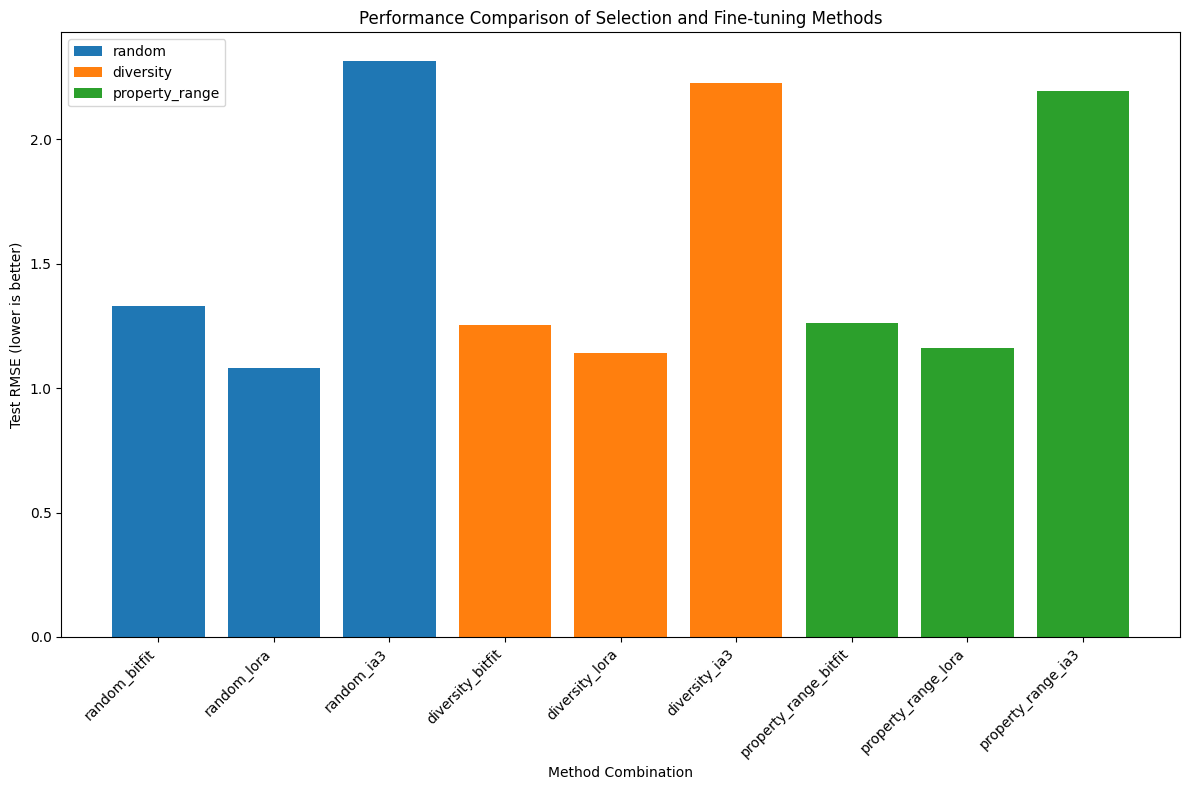

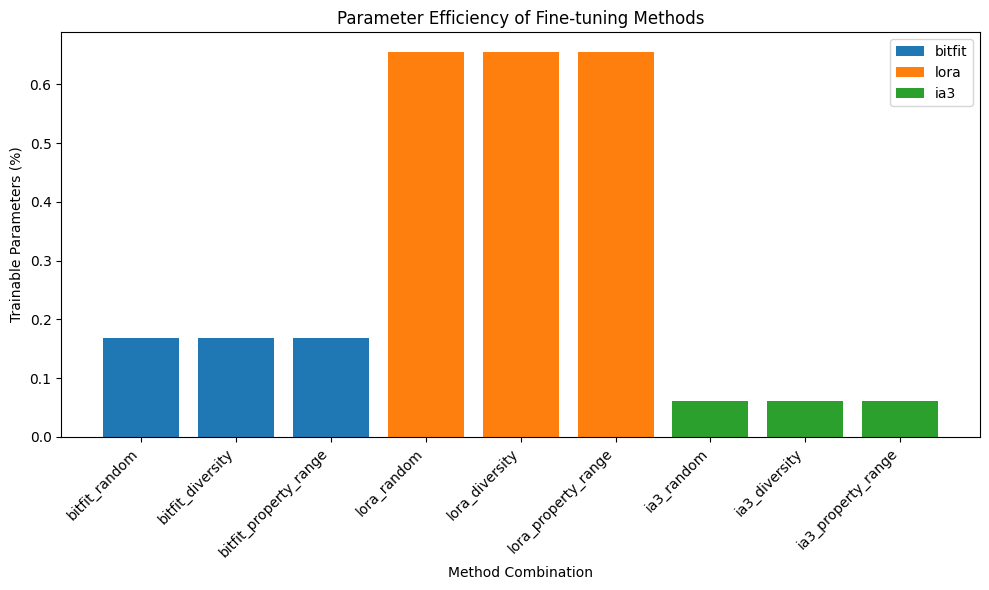


Results analysis completed. Visualizations saved to 'method_comparison.png' and 'parameter_efficiency.png'


In [18]:
if __name__ == "__main__":
    # Define data selection methods
    selection_methods = {
        'random': (random_selection, 'Random selection'),
        'diversity': (diversity_based_selection, 'Diversity-based selection'),
        'property_range': (property_range_selection, 'Property range selection')
    }
    
    # Define parameter-efficient fine-tuning methods
    ft_methods = {
        'bitfit': (BitFitModel, 'BitFit (bias-only fine-tuning)'),
        'lora': (LoRAModel, 'LoRA (Low-Rank Adaptation)'),
        'ia3': (iA3Model, 'iA3 (Implicit Adapter)')
    }
    
    # Dictionary to store all results
    all_results = {}
    
    # Run experiments
    # For a quick test, let's run one experiment with each combination
    for sel_key, (sel_method, sel_desc) in selection_methods.items():
        for ft_key, (ft_method, ft_desc) in ft_methods.items():
            # To make experiments faster, use a small percentage
            results = run_experiment(sel_method, sel_key, ft_method, ft_key, model, percentage=0.1)
            all_results[f"{sel_key}_{ft_key}"] = results
    
    # Analyze and compare results
    print("\n\n" + "="*50)
    print("SUMMARY OF ALL EXPERIMENTS")
    print("="*50)
    
    # Create a formatted table for results
    print("\n| Selection Method | Fine-tuning Method | Trainable Params (%) | Test RMSE | Test R² |")
    print("|------------------|-------------------|---------------------|-----------|---------|")
    
    for exp_name, results in all_results.items():
        sel_method = results['selection_method']
        ft_method = results['fine_tuning_method']
        trainable_pct = results['trainable_percentage']
        rmse = results['metrics']['rmse']
        r2 = results['metrics']['r2']
        
        print(f"| {sel_method.ljust(16)} | {ft_method.ljust(17)} | {trainable_pct:>19.2f}% | {rmse:>9.4f} | {r2:>7.4f} |")
    
    # Find the best performing method
    best_exp = min(all_results.items(), key=lambda x: x[1]['metrics']['rmse'])
    best_exp_name = best_exp[0]
    best_results = best_exp[1]
    
    print("\nBest performing method:")
    print(f"Selection method: {best_results['selection_method']}")
    print(f"Fine-tuning method: {best_results['fine_tuning_method']}")
    print(f"Test RMSE: {best_results['metrics']['rmse']:.4f}")
    print(f"Test R²: {best_results['metrics']['r2']:.4f}")
    print(f"Trainable parameters: {best_results['trainable_params']:,} ({best_results['trainable_percentage']:.2f}% of total)")
    
    # Create visualization of results
    plt.figure(figsize=(12, 8))
    
    # Group by selection method
    for sel_method in selection_methods.keys():
        rmse_values = []
        ft_labels = []
        
        for ft_method in ft_methods.keys():
            key = f"{sel_method}_{ft_method}"
            if key in all_results:
                rmse_values.append(all_results[key]['metrics']['rmse'])
                ft_labels.append(ft_method)
        
        plt.bar(
            [f"{sel_method}_{ft}" for ft in ft_labels], 
            rmse_values, 
            label=sel_method
        )
    
    plt.xlabel('Method Combination')
    plt.ylabel('Test RMSE (lower is better)')
    plt.title('Performance Comparison of Selection and Fine-tuning Methods')
    plt.xticks(rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.savefig('method_comparison.png')
    plt.show()
    
    # Plot the trainable parameters percentage
    plt.figure(figsize=(10, 6))
    
    for ft_method in ft_methods.keys():
        trainable_pcts = []
        sel_labels = []
        
        for sel_method in selection_methods.keys():
            key = f"{sel_method}_{ft_method}"
            if key in all_results:
                trainable_pcts.append(all_results[key]['trainable_percentage'])
                sel_labels.append(sel_method)
        
        plt.bar(
            [f"{ft_method}_{sel}" for sel in sel_labels], 
            trainable_pcts, 
            label=ft_method
        )
    
    plt.xlabel('Method Combination')
    plt.ylabel('Trainable Parameters (%)')
    plt.title('Parameter Efficiency of Fine-tuning Methods')
    plt.xticks(rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.savefig('parameter_efficiency.png')
    plt.show()
    
    print("\nResults analysis completed. Visualizations saved to 'method_comparison.png' and 'parameter_efficiency.png'")